In [682]:
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix , ConfusionMatrixDisplay
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, BatchNormalization, Conv2D
from tensorflow.keras.layers import ActivityRegularization,GaussianDropout,SpatialDropout2D,Dropout
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Flatten
from tensorflow.keras.layers import concatenate,Add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle as pkl
import pandas as pd

In [683]:
tf. __version__

'2.10.0'

In [684]:
model_name = 'C20'

In [685]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


<h1>Loading Dataset and images</h1>

In [686]:
train_df = pd.read_csv('./train.csv',index_col='id')
test_df = pd.read_csv('./test.csv',index_col='id')

In [687]:
train_df['label'] = train_df['label'].astype(str)

In [688]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.15,rotation_range=20,  # Random rotation
                             width_shift_range=0.2,  # Random horizontal shift
                             height_shift_range=0.2,  # Random vertical shift
                             shear_range=0.2,  # Random shear
                             horizontal_flip=True)

In [689]:
train_generator = datagen.flow_from_directory(
    directory="./imageset/train/",
    batch_size=16,
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=(224, 224),
    subset="training"
)
validation_generator = datagen.flow_from_directory(
    directory="./imageset/train/",
    batch_size=16,
    seed=42,
    shuffle=False,
    class_mode="sparse",
    target_size=(224, 224),
    subset="validation"  # Specify that this is the validation set
)

Found 8053 images belonging to 10 classes.
Found 1416 images belonging to 10 classes.


In [690]:
# Get a batch of images and labels
images, labels = validation_generator.next()

# Check pixel values of the images
min_value = np.min(images)
max_value = np.max(images)
print(min_value,max_value)

if min_value >= -1 and max_value <= 1:
    print("Images are rescaled between -1 and 1.")
else:
    print("Images are not rescaled between -1 and 1.")

0.0 1.0
Images are rescaled between -1 and 1.


In [691]:
# train_images = pkl.load(open('./train_images.pickle','rb'))
# test_images = pkl.load(open('./test_images.pickle','rb'))

In [692]:
# train_images = train_images[:100]
# train_df = train_df.iloc[:100]

In [693]:
# train_images.shape

In [694]:
# X_train,X_val,y_train,y_val = train_test_split(train_images,train_df['label'],random_state=42)

In [695]:
# X_train.shape,X_val.shape,y_train.shape

In [696]:
# train_images = None

<h1>Model Architecture</h1>

In [697]:
def Module_1(filters,previous_layer,kernel=(3,3)):
    x = Conv2D(filters,kernel_size=kernel,padding='same',activation='relu')(previous_layer)
    x = Conv2D(filters,kernel_size=kernel,padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    # x = ActivityRegularization(l2=0.00001)(x)
    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    return x

In [698]:
def Module_2(filters,previous_layer,kernel=(3,3)):
    x = Conv2D(filters,kernel_size=kernel,padding='same',activation='relu')(previous_layer)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    return x

In [699]:
def Module_3(filters,previous_layer):
    x = Conv2D(filters,kernel_size=(3,3),padding='same',activation='relu')(previous_layer)
    x = BatchNormalization()(x)
    x = ActivityRegularization(l2=0.0001)(x)
    return x

In [700]:
# def Module_4(filters,previous_layer):
#     x1 = Conv2D(filters,kernel_size=(3,3),padding='same',dilation_rate=(1,1),activation='relu')(previous_layer)
#     x = BatchNormalization()(x1)
#     # x = MaxPooling2D((2,2),strides=3,padding='same')(x)
#     x = GaussianDropout(0.5)(x)
#     x = SeparableConv2D(filters,kernel_size=(3,3),padding='same',dilation_rate=(1,1),activation='relu')(x)
#     x = BatchNormalization()(x)
#     # x = MaxPooling2D((2,2),strides=3,padding='same')(x)
#     x = SeparableConv2D(filters,kernel_size=(3,3),padding='same',dilation_rate=(1,1),activation='relu')(x)
#     x = Add()([x,x1])

#     # x = MaxPooling2D((2,2),padding='same')(x)
#     return x

In [701]:
# def load_model_1(input_shape=(224,224,3),lr=0.001,classes=10):
#     base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
#     x = base_model.output
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)
#     output = Dense(classes, activation='softmax')(x)
#     # this is the model we will train
#     model = Model(inputs=base_model.input, outputs=output)
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model
    

In [702]:
def load_model_2(input_shape=(224,224,3),lr=0.001,classes=10):
    # Model val_accuracy= 74%
    input_layer = Input(shape = input_shape,name='Input_layer')
    x = Module_1(filters=32,previous_layer=input_layer)
    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    x = Module_2(filters=16,previous_layer=x)
    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    x = Module_2(filters=64,previous_layer=x)
    x = Module_2(filters=32,previous_layer=x,kernel=(3,3))
    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    x = Module_2(filters=128,previous_layer=x,kernel=(3,3))
    x = Module_2(filters=48,previous_layer=x,kernel=(3,3))
    x = Module_2(filters=198,previous_layer=x,kernel=(3,3))

    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    x = Module_2(filters=198,previous_layer=x)
    x = Module_2(filters=128,previous_layer=x)
    # x1 = MaxPooling2D((2,2),strides=2,padding='same')(x)
    x1 = Module_2(filters=48,previous_layer=x)
    x1 = Module_2(filters=128,previous_layer=x1)

    # x1 = Add()[(x,x1)]

    # x = Module_2(filters=128,previous_layer=x,kernel=(3,3))

    # concat = Module_4(filters=256,previous_layer=concat)
    x = Flatten()(x1)
    x = Dense(128,activation='relu')(x)
    x = Dense(128,activation='relu')(x)
    # x = Dropout(0.3)(x)
    x = Dense(64,activation='relu')(x)
    x = Dense(32,activation='relu')(x)

    output = Dense(classes,activation='softmax')(x)
    model = Model(inputs=input_layer,outputs=output) 
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model
    

In [703]:
# def load_model_3(input_shape=(224,224,3),lr=0.001,classes=10):
#     base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=input_shape)
#     x = base_model.output
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)
#     output = Dense(classes, activation='softmax')(x)
#     # this is the model we will train
#     model = Model(inputs=base_model.input, outputs=output)
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model
    

In [704]:
# model = load_model_1(input_shape=train_generator.image_shape,lr=0.0001)
model = load_model_2(input_shape=train_generator.image_shape,lr=0.001)
# model = load_model_3(input_shape=train_generator.image_shape,lr=0.0001)
# model = load_model()

c:\Users\Hazim\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [705]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_276 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 conv2d_277 (Conv2D)         (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_236 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_134 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 56, 56, 32)       0  

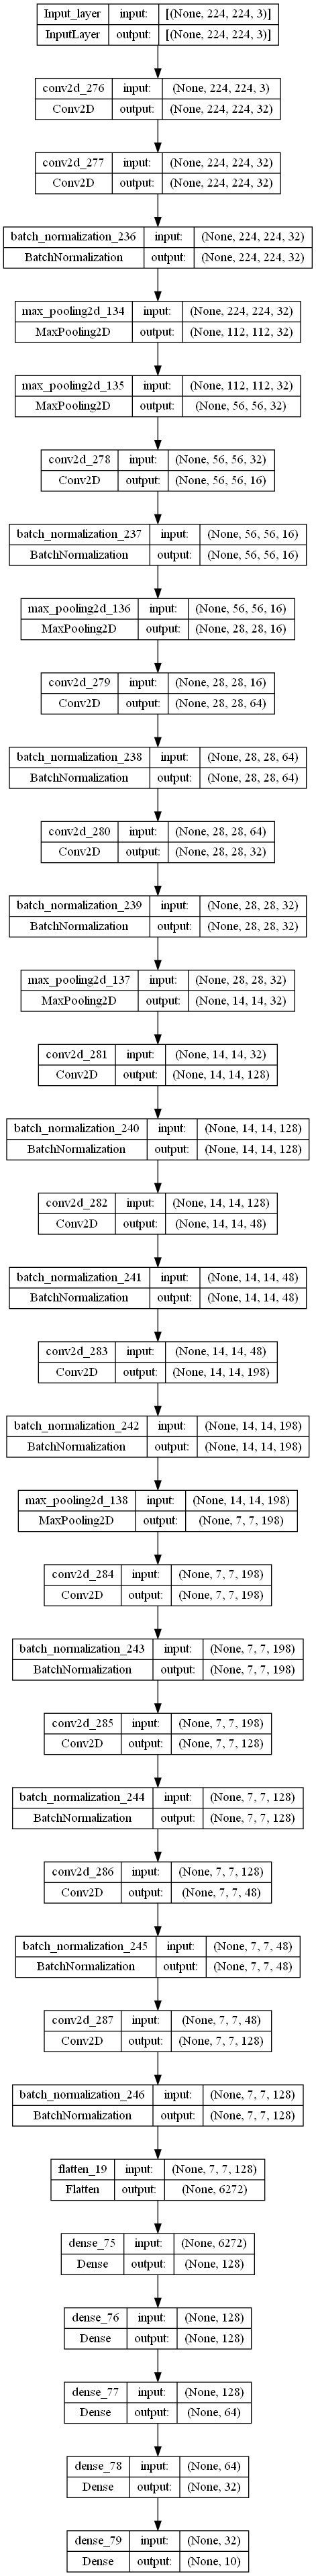

In [706]:
plot_model(model,show_shapes=True, show_layer_names=True)

In [707]:
# Define the checkpoint path and early stopping
checkpoint_path = f"model_checkpoint_class_{model_name}.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True,monitor='val_accuracy',mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
# Loads the weights
# model.load_weights(checkpoint_path)

In [708]:
history = model.fit(train_generator,steps_per_epoch=len(train_generator),
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    verbose=1,
                    callbacks=[checkpoint,early_stopping])

Epoch 1/100
504/504 [==============================] - 112s 216ms/step - loss: 2.1524 - accuracy: 0.2210 - val_loss: 2.4672 - val_accuracy: 0.2013
Epoch 2/100
504/504 [==============================] - 109s 216ms/step - loss: 1.9763 - accuracy: 0.2912 - val_loss: 2.0025 - val_accuracy: 0.2966
Epoch 3/100
504/504 [==============================] - 149s 296ms/step - loss: 1.8337 - accuracy: 0.3458 - val_loss: 2.5499 - val_accuracy: 0.2076
Epoch 4/100
 18/504 [>.............................] - ETA: 2:38 - loss: 1.8127 - accuracy: 0.3854

KeyboardInterrupt: 

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
def plot_history(history,metrics):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(f'model {metrics}')
    plt.ylabel(f'{metrics}') 
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

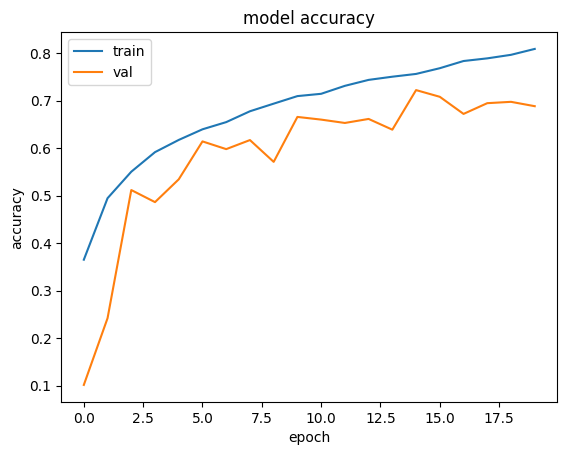

In [ ]:
plot_history(history,metrics='accuracy')

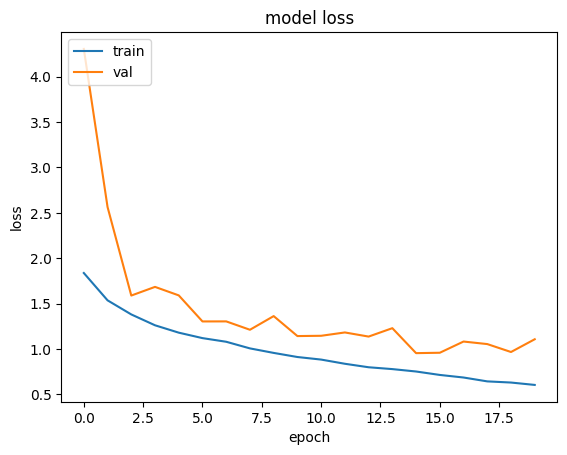

In [ ]:
plot_history(history,metrics='loss')

In [ ]:
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size+1
model.evaluate(validation_generator,
steps=STEP_SIZE_VALID)

45/45 [==============================] - 16s 358ms/step - loss: 0.9632 - accuracy: 0.7182


[0.963202714920044, 0.7182203531265259]

In [ ]:
# Get true labels for validation set
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size+1
validation_generator.reset()
y_pred=model.predict(validation_generator,
steps=STEP_SIZE_TEST,
verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = validation_generator.classes


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

45/45 [==============================] - 17s 365ms/step


In [ ]:
np.unique(y_pred_classes)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Accuracy: 0.7146892655367232
Classwise Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.69      0.80       144
           1       0.84      0.80      0.82       143
           2       0.64      0.88      0.74       144
           3       0.79      0.67      0.73       148
           4       0.59      0.48      0.53       128
           5       0.57      0.81      0.67       141
           6       0.89      0.73      0.80       143
           7       0.75      0.78      0.76       144
           8       0.61      0.58      0.60       139
           9       0.67      0.70      0.68       142

    accuracy                           0.71      1416
   macro avg       0.73      0.71      0.71      1416
weighted avg       0.73      0.71      0.72      1416


Confusion Matrix: 


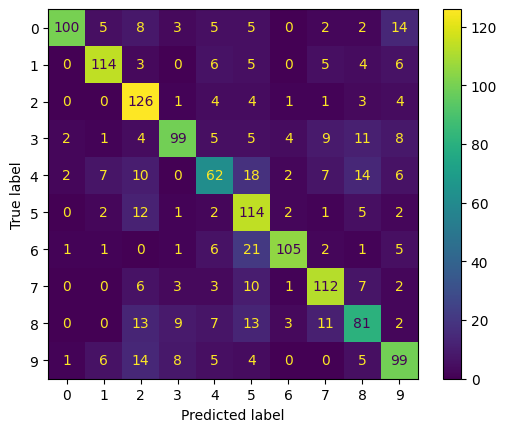

In [ ]:
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes)}")
print(f"Classwise Classification Report: \n{classification_report(y_true, y_pred_classes)}")
con_matrix = confusion_matrix(np.ravel(y_true), y_pred_classes)
print("\nConfusion Matrix: ")
con_matrix = ConfusionMatrixDisplay(con_matrix)
con_matrix.plot()
plt.show()

In [ ]:
model.save(f'./Models/{model_name}_custom.h5')

In [ ]:
# Load the model from the file
model = load_model(f"./Models/{model_name}_custom.h5")